In [1]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging
from functools import wraps
from tabulate import tabulate
from wordcloud import WordCloud  # importing the worldcloud module. Wordcloud uses the text sizes to represent the frequency of the text
import sweetviz as sv



Bad key "text.kerning_factor" on line 4 in
D:\Anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import os
os.getcwd()

'D:\\Data Science Projects\\Courses\\Jigsaw Academy\\Student Early Attrition'

In [3]:
def function_timer(function_run):
    import time
    
    @wraps(function_run)
    def wrapper(*args, **kwargs):
        t1 = time.time()
        result = function_run(*args, **kwargs)
        t2 = time.time() - t1
        print(f"Function {function_run.__name__} ran in : {t2} seconds")
        return result
    return wrapper

In [4]:
os.chdir("D:/Full Stack Data Science Course/Capstone Project/Students' Early Attrition Modelling on Python")

In [5]:
StudentApplications=pd.read_excel('Student Applications & Performance.xlsx',header=0)

In [6]:
StudentApplications.loc[StudentApplications["RETURNED_2ND_YR"] == 1, "Dint_Return_2nd_Yr"] = 0

In [7]:
StudentApplications.loc[StudentApplications["RETURNED_2ND_YR"] == 0, "Dint_Return_2nd_Yr"] = 1

In [8]:
StudentApplications = StudentApplications.drop(columns="RETURNED_2ND_YR")

In [11]:
#Data Quality Report
class DataSummary():
    def __init__(self, Dataset):
        self.Dataset = Dataset
    
    @function_timer
    def DQReport(self):
        DQReport = self.Dataset.describe(include='all').transpose()
        DQReport["Dtype"]=self.Dataset.dtypes
        Unique_Values=[len(self.Dataset[i].unique()) for i in self.Dataset.columns.tolist()]
        DummySeries=pd.Series(Unique_Values)
        DQReport["Unique"]=DummySeries.values
        Missing_Values=[self.Dataset[i].isna().sum() for i in self.Dataset.columns.tolist()]
        DummySeries=pd.Series(Missing_Values)
        DQReport["Missing"]=DummySeries.values
        DQReport["Available Data"]=DQReport["count"]-DQReport["Missing"]
        DQReport=DQReport.drop(['unique','top', 'freq'], axis=1)
        DQReport.to_excel('DQReport.xlsx',index=True)

In [12]:
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)

class Event_Rates:
    def __init__(self, Dataset):
        self.Dataset = Dataset
        
    def __str__(self):
        return f"Event_Rates({Dataset})"
    
    @function_timer
    def Categorical_Variable(self, nonZero_Column, Label_Binary, Variable_Name = None):
        pd.options.display.width=None
        Binning_Dataset = self.Dataset.groupby(Variable_Name,as_index=False).agg({Label_Binary:np.sum})
        Values_in_Column=Series(self.Dataset.groupby(Variable_Name,as_index=False).agg({nonZero_Column:np.count_nonzero})[nonZero_Column].values)
        Binning_Dataset["Values_in_Column"]=Values_in_Column.values
        Binning_Dataset[f"{Label_Binary}_Perc"]=Binning_Dataset[Label_Binary]/Binning_Dataset["Values_in_Column"]
        print("\n")
        return Binning_Dataset
    
    @function_timer
    def Numerical_Variable(self, nonZero_Column, Bins, Label_Binary, Variable_Name):
        pd.options.display.width=None
        for i in reversed(range(1,Bins+1)):
            try:
                print(f"For variable {Variable_Name}")
                self.Dataset["Bins"]=pd.qcut(self.Dataset[Variable_Name], q = i)
                Binning_Dataset = self.Dataset.groupby('Bins',as_index=False).agg({Label_Binary:np.sum})
                Values_in_Column=Series(self.Dataset.groupby('Bins',as_index=False).agg({nonZero_Column:np.count_nonzero})[nonZero_Column].values)
                self.Dataset['Bins'].value_counts()
                Binning_Dataset["Values_in_Column"]=Values_in_Column.values
                Binning_Dataset[f"{Label_Binary}_Perc"]=Binning_Dataset[Label_Binary]/Binning_Dataset["Values_in_Column"]
                self.Dataset.drop(["Bins"], axis=1, inplace = True)
                print("\n")
                return Binning_Dataset
                break
            except Exception as e:
                print(f"Generating {str(i)} bins is not possible.Hence generating {str(i-1)} bins \n")
           
    @function_timer    
    def Missing(self, nonZero_Column, Label_Binary, Variable_Name):
        pd.options.display.width=None
        self.Dataset.loc[self.Dataset[Variable_Name].isna(), "Missing"] = 1
        self.Dataset.loc[-self.Dataset[Variable_Name].isna(), "Missing"] = 0
        Missing_Dataset = self.Dataset.groupby('Missing',as_index=False).agg({Label_Binary:np.sum})
        Values_in_Column=Series(self.Dataset.groupby("Missing",as_index=False).agg({nonZero_Column:np.count_nonzero})[nonZero_Column].values)
        Missing_Dataset["Values_in_Column"]=Values_in_Column.values
        Missing_Dataset[f"{Label_Binary}_Perc"]=Missing_Dataset[Label_Binary]/Missing_Dataset["Values_in_Column"]
        return Missing_Dataset
   
    @function_timer
    def All_Variables(self, nonZero_Column, Label_Binary, Variable_Type, Bins = None):
        #Categorical = 0
        pd.options.display.width=None
        if Variable_Type==0:
            for i in range(len(self.Dataset.columns)):
                if (not np.issubdtype(self.Dataset[self.Dataset.columns[i]], np.number)) and self.Dataset.columns[i]!=nonZero_Column and  self.Dataset.columns[i]!=Label_Binary:
                    Binning_DF = self.Categorical_Variable(nonZero_Column,Label_Binary,self.Dataset.columns[i])
                    yield Binning_DF            
                    
        #Numerical = 1
        if Variable_Type==1:
            for i in range(len(self.Dataset.columns)):
                if np.issubdtype(self.Dataset[self.Dataset.columns[i]], np.number) and self.Dataset.columns[i]!=nonZero_Column and  self.Dataset.columns[i]!=Label_Binary:
                    Binning_DF = self.Numerical_Variable(nonZero_Column, Bins, Label_Binary,self.Dataset.columns[i])
                    yield Binning_DF

In [13]:
pd.options.display.width=None
pd.options.display.max_columns = None
er = Event_Rates(StudentApplications)
Bins = er.All_Variables("STDNT_AGE", "Dint_Return_2nd_Yr", 0)
for i in Bins:
    print(tabulate(i, headers='keys', tablefmt='psql'))

Function All_Variables ran in : 0.0 seconds


Function Categorical_Variable ran in : 0.545543909072876 seconds
+----+----------------+----------------------+--------------------+---------------------------+
|    | STDNT_GENDER   |   Dint_Return_2nd_Yr |   Values_in_Column |   Dint_Return_2nd_Yr_Perc |
|----+----------------+----------------------+--------------------+---------------------------|
|  0 | F              |                  475 |               2140 |                  0.221963 |
|  1 | M              |                  248 |               1260 |                  0.196825 |
+----+----------------+----------------------+--------------------+---------------------------+


Function Categorical_Variable ran in : 0.0242154598236084 seconds
+----+--------------------+----------------------+--------------------+---------------------------+
|    | STDNT_BACKGROUND   |   Dint_Return_2nd_Yr |   Values_in_Column |   Dint_Return_2nd_Yr_Perc |
|----+--------------------+------------------



Function Categorical_Variable ran in : 0.01651930809020996 seconds
+----+------------------------+----------------------+--------------------+---------------------------+
|    | CORE_COURSE_NAME_3_F   |   Dint_Return_2nd_Yr |   Values_in_Column |   Dint_Return_2nd_Yr_Perc |
|----+------------------------+----------------------+--------------------+---------------------------|
|  0 | ANTH 1105              |                    7 |                 14 |                 0.5       |
|  1 | ANTH 1107              |                    0 |                  1 |                 0         |
|  2 | ARTH 1100              |                   21 |                 76 |                 0.276316  |
|  3 | ARTH 1100I             |                    1 |                  5 |                 0.2       |
|  4 | ASTR 1105              |                    0 |                  2 |                 0         |
|  5 | ASTR 1305              |                    0 |                  2 |                 0      


Function Categorical_Variable ran in : 0.02230048179626465 seconds
+----+------------------------+----------------------+--------------------+---------------------------+
|    | CORE_COURSE_NAME_3_S   |   Dint_Return_2nd_Yr |   Values_in_Column |   Dint_Return_2nd_Yr_Perc |
|----+------------------------+----------------------+--------------------+---------------------------|
|  0 | ANTH 1105              |                    1 |                  8 |                 0.125     |
|  1 | ANTH 1105I             |                    1 |                  6 |                 0.166667  |
|  2 | ANTH 1107              |                    0 |                  1 |                 0         |
|  3 | ARTH 1100              |                    6 |                 41 |                 0.146341  |
|  4 | ASTR 1105              |                    0 |                  1 |                 0         |
|  5 | BIOL 1125              |                    0 |                  5 |                 0       

+-----+------------------+----------------------+--------------------+---------------------------+


Function Categorical_Variable ran in : 0.013942956924438477 seconds
+----+---------------------------+----------------------+--------------------+---------------------------+
|    | FATHER_HI_EDU_DESC        |   Dint_Return_2nd_Yr |   Values_in_Column |   Dint_Return_2nd_Yr_Perc |
|----+---------------------------+----------------------+--------------------+---------------------------|
|  0 | College/Beyond            |                  257 |               1309 |                  0.196333 |
|  1 | High School               |                  289 |               1336 |                  0.216317 |
|  2 | Middle School/Junior High |                   26 |                 97 |                  0.268041 |
|  3 | No Information            |                  103 |                432 |                  0.238426 |
|  4 | Other/Unknown             |                   48 |                226 |    

In [14]:
pd.options.display.width=None
er = Event_Rates(StudentApplications)
Bins = er.All_Variables("STDNT_AGE", "Dint_Return_2nd_Yr", 1, 10)

for i in Bins:
    print(tabulate(i, headers='keys', tablefmt='psql'))

Function All_Variables ran in : 0.0 seconds
For variable STUDENT IDENTIFIER


Function Numerical_Variable ran in : 0.033966064453125 seconds
+----+--------------------------+----------------------+--------------------+---------------------------+
|    | Bins                     |   Dint_Return_2nd_Yr |   Values_in_Column |   Dint_Return_2nd_Yr_Perc |
|----+--------------------------+----------------------+--------------------+---------------------------|
|  0 | (7755836.999, 7785577.3] |                   73 |                340 |                  0.214706 |
|  1 | (7785577.3, 7812600.0]   |                   71 |                340 |                  0.208824 |
|  2 | (7812600.0, 7840215.6]   |                   73 |                340 |                  0.214706 |
|  3 | (7840215.6, 7870969.2]   |                   58 |                340 |                  0.170588 |
|  4 | (7870969.2, 7899052.5]   |                   66 |                340 |                  0.194118 |
|  5 | (789

Generating 10 bins is not possible.Hence generating 9 bins 

For variable MOTHER_HI_EDU_CD
Generating 9 bins is not possible.Hence generating 8 bins 

For variable MOTHER_HI_EDU_CD
Generating 8 bins is not possible.Hence generating 7 bins 

For variable MOTHER_HI_EDU_CD
Generating 7 bins is not possible.Hence generating 6 bins 

For variable MOTHER_HI_EDU_CD
Generating 6 bins is not possible.Hence generating 5 bins 

For variable MOTHER_HI_EDU_CD
Generating 5 bins is not possible.Hence generating 4 bins 

For variable MOTHER_HI_EDU_CD
Generating 4 bins is not possible.Hence generating 3 bins 

For variable MOTHER_HI_EDU_CD


Function Numerical_Variable ran in : 0.06170248985290527 seconds
+----+--------------+----------------------+--------------------+---------------------------+
|    | Bins         |   Dint_Return_2nd_Yr |   Values_in_Column |   Dint_Return_2nd_Yr_Perc |
|----+--------------+----------------------+--------------------+---------------------------|
|  0 | (0.999, 2.0] 



Function Numerical_Variable ran in : 0.05426359176635742 seconds
+----+-----------------------+----------------------+--------------------+---------------------------+
|    | Bins                  |   Dint_Return_2nd_Yr |   Values_in_Column |   Dint_Return_2nd_Yr_Perc |
|----+-----------------------+----------------------+--------------------+---------------------------|
|  0 | (-0.001, 150540.0]    |                  353 |               1711 |                  0.206312 |
|  1 | (150540.0, 2124900.0] |                  370 |               1689 |                  0.219065 |
+----+-----------------------+----------------------+--------------------+---------------------------+
For variable EST_FAM_CONTRIBUTION
Generating 10 bins is not possible.Hence generating 9 bins 

For variable EST_FAM_CONTRIBUTION
Generating 9 bins is not possible.Hence generating 8 bins 

For variable EST_FAM_CONTRIBUTION
Generating 8 bins is not possible.Hence generating 7 bins 

For variable EST_FAM_CONTRIBUTIO

In [15]:
#the below class can be used for binary classification related missing value imputation.

class Missing_Value_Imputation:
    def __init__(self, Dataset):
        self.Dataset = Dataset
        self.evt = Event_Rates(self.Dataset)
    
    @function_timer
    def Categorical_Using_EventRates(self, nonZero_Column, Label_Binary, Col_Name):     
        if self.Dataset[Col_Name].isna().sum()==0:
            print(f"{Col_Name} does not have any missing values")
            
        else:
            Binning_Dataset = self.evt.Categorical_Variable(nonZero_Column, Label_Binary, Col_Name)
            Missing_Dataset = self.evt.Missing(nonZero_Column, Label_Binary, Col_Name)
            
            Diff_in_Perc=[abs(Missing_Dataset[f"{Label_Binary}_Perc"][1]-Binning_Dataset[f"{Label_Binary}_Perc"][i]) for i in range(len(Binning_Dataset))]
            self.Dataset.loc[self.Dataset[Col_Name].isna(), Col_Name] = Binning_Dataset[Col_Name][Diff_in_Perc.index(min(Diff_in_Perc))]
            
            imputed = Binning_Dataset[Col_Name][Diff_in_Perc.index(min(Diff_in_Perc))]
            Label_BinaryPercent = Missing_Dataset[f"{Label_Binary}_Perc"][1]
            print(f" {Label_Binary} Event Rates for the column {Col_Name} \n \n {tabulate(Binning_Dataset, headers='keys', tablefmt='psql')} \n \n")
            print(f" {Label_Binary} Event Rates for missing values in the column \n \n {tabulate(Missing_Dataset, headers='keys', tablefmt='psql')}")
            print(f"Imputed value {imputed} in missing values in column {Col_Name} as {Label_Binary}_Perc for missing values is {Label_BinaryPercent} and {Label_Binary}_Perc for {Col_Name} is close to that")

            self.Dataset.drop(["Missing"], axis=1, inplace = True)
            del(Diff_in_Perc, Binning_Dataset, Missing_Dataset)
            return imputed
            
        
#the below method works the same way as the above method. Only difference is that instead of having categories in the output - 
# this method has bins of values.
    @function_timer
    def Numerical_using_EventRates(self, nonZero_Column, Bins, Label_Binary, Col_Name):
        if self.Dataset[Col_Name].isna().sum()==0:
            print(f"{Col_Name} does not have any missing values")
            
        else:
            Binning_Dataset = self.evt.Numerical_Column(nonZero_Column, Bins, Label_Binary, Col_Name)
            Missing_Dataset = self.evt.Missing(nonZero_Column, Label_Binary, Col_Name)
            
            for i in reversed(range(Bins)):
                try: 
                    Diff_in_Perc=[abs(Missing_Dataset[f"{Label_Binary}_Perc"][1]-Binning_Dataset[f"{Label_Binary}_Perc"][i]) for i in range(len(Binning_Dataset))]
                    imputed = (Binning_Dataset["Bins"][Diff_in_Perc.index(min(Diff_in_Perc))].left+Binning_Dataset["Bins"][Diff_in_Perc.index(min(Diff_in_Perc))].right)/2
                    imputed_Bin = Binning_Dataset["Bins"][Diff_in_Perc.index(min(Diff_in_Perc))]
                    imputed_Label_Binary_Perc = Binning_Dataset[f"{Label_Binary}_Perc"][Diff_in_Perc.index(min(Diff_in_Perc))]
                    self.Dataset.loc[self.Dataset[Col_Name].isna(), Col_Name] = imputed        
                    Label_BinaryPercent = Missing_Dataset[f"{Label_Binary}_Perc"][1]
                    print(f" {Label_Binary} Event Rates for the column {Col_Name} \n \n {tabulate(Binning_Dataset, headers='keys', tablefmt='psql')} \n \n")
                    print(f" {Label_Binary} Event Rates for missing values in the column \n \n {tabulate(Missing_Dataset, headers='keys', tablefmt='psql')}")
                    print(f"Imputed value {imputed} in missing values in column {Col_Name} as {Label_Binary}_Perc for missing values is {Label_BinaryPercent} and for bin {imputed_Bin} is {imputed_Label_Binary_Perc} and {Label_Binary}_Perc for {Col_Name} is close to that")
                    del(Diff_in_Perc, Binning_Dataset, Missing_Dataset)
                    self.Dataset.drop(["Missing"], axis=1, inplace = True)
                    return imputed
                   
                    break
                except:
                    pass
           

# Other options for missing value imputation are using python's missingpy library or scikit-learn's Iterative function, statsmodels MICE and fancyimpute library. You can also use forward fill method for imputation

In [16]:
mv = Missing_Value_Imputation(StudentApplications)
mv.Categorical_Using_EventRates("STDNT_AGE", "Dint_Return_2nd_Yr", "STDNT_TEST_ENTRANCE2")



Function Categorical_Variable ran in : 0.00670170783996582 seconds
Function Missing ran in : 0.16917109489440918 seconds
 Dint_Return_2nd_Yr Event Rates for the column STDNT_TEST_ENTRANCE2 
 
 +-----+------------------------+----------------------+--------------------+---------------------------+
|     |   STDNT_TEST_ENTRANCE2 |   Dint_Return_2nd_Yr |   Values_in_Column |   Dint_Return_2nd_Yr_Perc |
|-----+------------------------+----------------------+--------------------+---------------------------|
|   0 |                    350 |                    1 |                  1 |                 1         |
|   1 |                    360 |                    2 |                  2 |                 1         |
|   2 |                    370 |                    0 |                  3 |                 0         |
|   3 |                    390 |                    0 |                  3 |                 0         |
|   4 |                    400 |                    0 |               

970.0

In [26]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

formatter = logging.Formatter('%(asctime)s:%(name)s:%(levelname)s:%(funcName)s:%(message)s')

file_handler = logging.FileHandler("Categories.log")
file_handler.setFormatter(formatter)

logger.addHandler(file_handler)


class Category_Reduction:
    def __init__(self, Label, Dataset, Col_Name):
        self.Label = Label
        self.Dataset = Dataset
        self.Col_Name = Col_Name
        self.evt = Event_Rates(self.Dataset)
        # Plotiing the wordcloud for the Nationalit column
        plt.subplots(figsize=(25,15))
        wordcloud = WordCloud(
              background_color='white',
              width=1920,
              height=1080
             ).generate(" ".join(Dataset[Col_Name]))
        plt.imshow(wordcloud)
        plt.axis('off')
        plt.savefig('graph.png')
        plt.show()
        
    @function_timer
    def Combine_Categories(self, Combination_Magitude, Non_Zero_Column):

        pd.options.display.max_columns = None
        
        Binning_DF = self.evt.Categorical_Variable(Non_Zero_Column, self.Label, self.Col_Name)
        logger.info(f"\n Event Rates for {self.Col_Name} : \n {tabulate(Binning_DF, headers='keys', tablefmt='psql')}")

        Category1 = []
        Category2 = []
        Diff_in_EventRates = []

        for i in range(len(Binning_DF[f"{self.Label}_Perc"])):
            for j in range(len(Binning_DF[f"{self.Label}_Perc"])):
                if i!=j and i<j:
                    Category1.append(Binning_DF.iloc[i,0])
                    Category2.append(Binning_DF.iloc[j,0])
                    Diff_in_EventRates.append(Binning_DF[f"{self.Label}_Perc"][i]-Binning_DF[f"{self.Label}_Perc"][j])
        Difference_Dict = {'Category1':Category1, 'Category2':Category2, 'Diff_in_EventRates': Diff_in_EventRates}
        pd.set_option('display.max_rows', 3000)
        Difference_DF = pd.DataFrame(Difference_Dict)
        Difference_DF[Difference_DF["Diff_in_EventRates"]==(min(abs(Difference_DF["Diff_in_EventRates"])))]
        Difference_DF["Diff_in_EventRates"] = abs(Difference_DF["Diff_in_EventRates"])
        Difference_DF.sort_values(by="Diff_in_EventRates", inplace = True)
        Difference_DF.reset_index(inplace=True)
        
        del Difference_DF['index']

        for i in range(Combination_Magitude):
            condition1 = (self.Dataset[self.Col_Name]==(Difference_DF['Category1'][i]))|(self.Dataset[self.Col_Name].str.contains("&"+Difference_DF['Category1'][i]))
            Combined_Column_str1=self.Dataset[condition1][self.Col_Name]+"&"+Difference_DF['Category2'][i]+"&"
            for j in Combined_Column_str1:
                j = j.split(sep="&")
                j = sorted(j)
                j = np.unique(j)
                j = "&".join(j)
                j = j+"&"
            self.Dataset.loc[condition1,self.Col_Name]=j
            condition2 = (self.Dataset[self.Col_Name]==(Difference_DF['Category2'][i]))|(self.Dataset[self.Col_Name].str.contains("&"+Difference_DF['Category2'][i]))
            Combined_Column_str2=self.Dataset[condition2][self.Col_Name]+"&"+Difference_DF['Category1'][i]+"&"
            for k in Combined_Column_str2:
                k= k.split(sep="&")
                k = sorted(k)
                k = np.unique(k)
                k = "&".join(k)
                k = k+"&"
            self.Dataset.loc[condition2,self.Col_Name]=k
        
        
        logger.info(f"\n Event Rates differences: \n \n {tabulate(Difference_DF, headers='keys', tablefmt='psql')}")
        
        


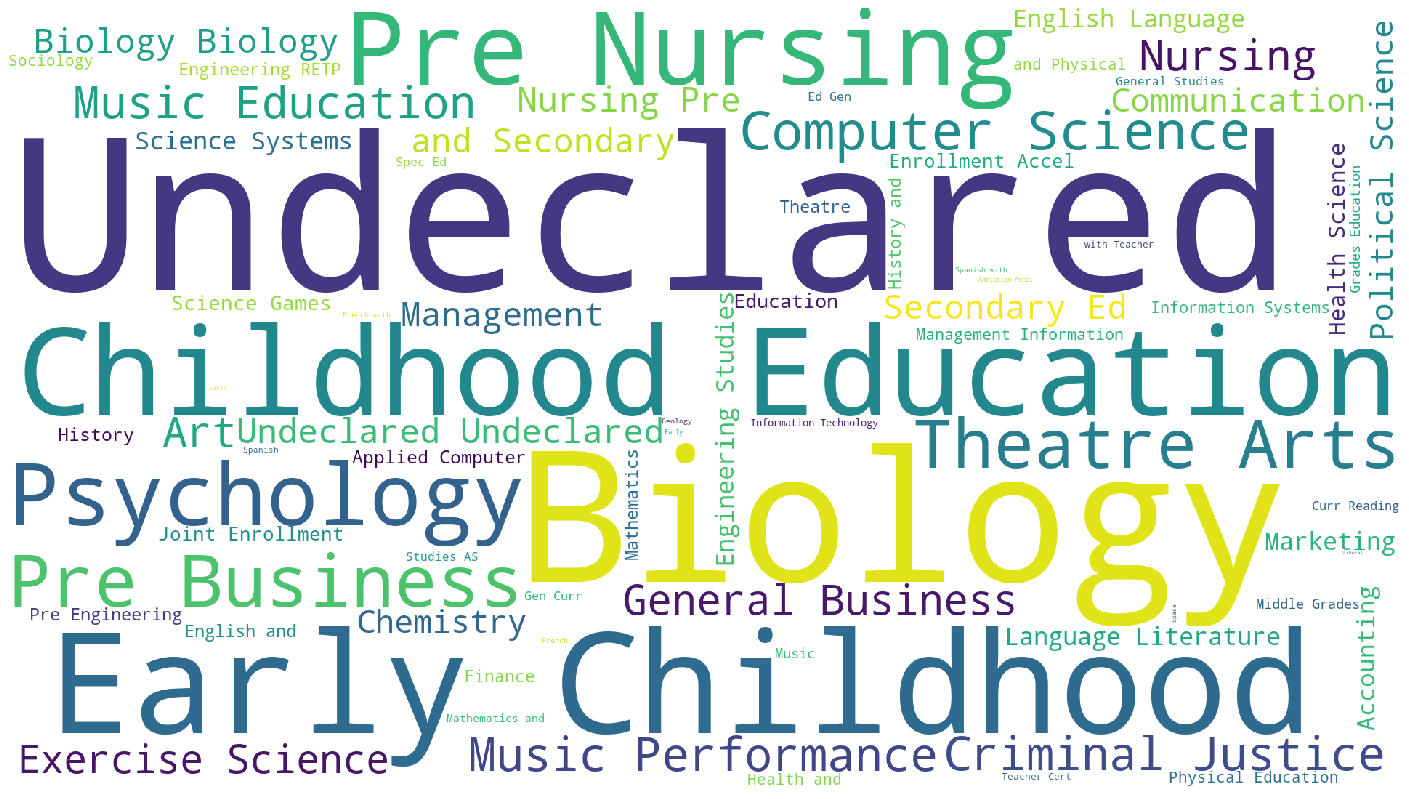



Function Categorical_Variable ran in : 0.0 seconds
Function Combine_Categories ran in : 2.8607704639434814 seconds


In [27]:
cr = Category_Reduction("Dint_Return_2nd_Yr", StudentApplications, "STDNT_MAJOR")
cr.Combine_Categories(100, "STDNT_AGE")

In [37]:
len(np.unique(StudentApplications['STDNT_MAJOR']))

12

In [38]:
np.unique(StudentApplications["STDNT_MAJOR"])

array(['&Applied Computer Science&Chemistry&Chemistry and Secondary Ed&Computer Science - Systems&Early Admission - Accel&English Language/Literature&English and Secondary Ed&General Business&Geology&Joint Enrollment - Accel&Liberal Arts&Spanish&',
       '&Art&Biology&Engineering Studies&Exercise Science&French&French with Teacher Cert&Health and Physical Education&History&Nursing&Pre-Business&Spanish with Teacher Cert&Spec Ed: Gen. Curr. - Reading&Undeclared&',
       '&Communication&Early Childhood Education&Management&Sociology&',
       '&Computer Science - Games&Music&',
       '&Criminal Justice&Information Technology&',
       '&Health Science&Music Performance&', 'Biology and Secondary Ed',
       'Earth and Space Science', 'General Studies/AS',
       'Middle Grades Education', 'Psychology', 'Theatre Education'],
      dtype=object)

In [39]:
# Checking if FATHER_HI_EDU_CD and FATHER_HI_EDU_DESC are same. doing same for mother
CatDec = StudentApplications.groupby("FATHER_HI_EDU_CD",as_index=False).agg({"Dint_Return_2nd_Yr":np.sum})
M=Series(StudentApplications.groupby("FATHER_HI_EDU_CD",as_index=False).agg({"STUDENT IDENTIFIER":np.count_nonzero})['STUDENT IDENTIFIER'].values)
CatDec["N"]=M.values
CatDec["Attrite_Perc"]=CatDec["Dint_Return_2nd_Yr"]/CatDec["N"]
print(CatDec)

CatDec = StudentApplications.groupby("MOTHER_HI_EDU_CD",as_index=False).agg({"Dint_Return_2nd_Yr":np.sum})
M=Series(StudentApplications.groupby("MOTHER_HI_EDU_CD",as_index=False).agg({"STUDENT IDENTIFIER":np.count_nonzero})['STUDENT IDENTIFIER'].values)
CatDec["N"]=M.values
CatDec["Attrite_Perc"]=CatDec["Dint_Return_2nd_Yr"]/CatDec["N"]
print(CatDec)



   FATHER_HI_EDU_CD  Dint_Return_2nd_Yr     N  Attrite_Perc
0               1.0                 168    97      1.731959
1               2.0                2383  1336      1.783683
2               3.0                2361  1309      1.803667
3               4.0                 404   226      1.787611
   MOTHER_HI_EDU_CD  Dint_Return_2nd_Yr     N  Attrite_Perc
0               1.0                 126    71      1.774648
1               2.0                2181  1223      1.783320
2               3.0                2699  1500      1.799333
3               4.0                 216   117      1.846154


In [40]:
StudentApplications = StudentApplications.drop(columns=["FATHER_HI_EDU_CD", "MOTHER_HI_EDU_CD", "DEGREE_GROUP_CD"])

In [41]:
StudentApplications = StudentApplications.drop(columns=["STUDENT IDENTIFIER"])

In [42]:
StudentApplications.describe()

,STDNT_AGE,STDNT_TEST_ENTRANCE1,STDNT_TEST_ENTRANCE2,STDNT_TEST_ENTRANCE_COMB,FIRST_TERM,SECOND_TERM,DISTANCE_FROM_HOME,HIGH_SCHL_GPA,FIRST_TERM_ATTEMPT_HRS,FIRST_TERM_EARNED_HRS,SECOND_TERM_ATTEMPT_HRS,SECOND_TERM_EARNED_HRS,GROSS_FIN_NEED,COST_OF_ATTEND,EST_FAM_CONTRIBUTION,UNMET_NEED
count,3400.000000,1106.000000,3400.000000,2882.000000,3400.000000,3400.000000,3375.000000,3347.000000,3400.000000,3400.000000,3194.000000,3191.000000,3.400000e+03,3.400000e+03,3.400000e+03,3.400000e+03
mean,17.994118,20.660036,966.402941,997.758501,200777.000000,200871.000000,99.825185,3.202738,13.985882,12.205000,14.285848,12.511125,3.034025e+05,5.515335e+05,3.446899e+05,7.222052e+04
std,0.552052,3.234734,179.008505,156.268221,170.001298,170.001298,235.196984,0.455337,1.554286,2.986294,2.104387,3.470492,4.836255e+05,6.064403e+05,7.871878e+05,2.795679e+05
min,16.000000,8.000000,350.000000,530.000000,200508.000000,200602.000000,0.000000,0.000000,9.000000,0.000000,2.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,-1.212072e+06
25%,18.000000,18.000000,940.000000,910.000000,200608.000000,200702.000000,69.000000,2.870000,13.000000,11.000000,13.000000,11.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,18.000000,20.000000,970.000000,990.000000,200808.000000,200902.000000,69.000000,3.200000,14.000000,13.000000,14.000000,13.000000,0.000000e+00,1.505400e+05,0.000000e+00,0.000000e+00
75%,18.000000,22.000000,1050.000000,1110.000000,200908.000000,201002.000000,138.000000,3.560000,15.000000,15.000000,16.000000,15.000000,5.995800e+05,1.192815e+06,3.241800e+05,1.876155e+05
max,26.000000,32.000000,1490.000000,1510.000000,201008.000000,201102.000000,5932.000000,4.000000,21.000000,21.000000,23.000000,23.000000,2.124900e+06,2.124900e+06,5.999940e+06,1.632660e+06


In [12]:
StudentApplications.loc[StudentApplications["Dint_Return_2nd_Yr"] == 1, "Dint_Return_2nd_Yr"] = True
StudentApplications.loc[StudentApplications["Dint_Return_2nd_Yr"] == 0, "Dint_Return_2nd_Yr"] = False
my_report = sv.analyze(StudentApplications, target_feat = "Dint_Return_2nd_Yr")
my_report.show_html() # Default arguments w
StudentApplications.loc[StudentApplications["Dint_Return_2nd_Yr"] == True, "Dint_Return_2nd_Yr"] = 1
StudentApplications.loc[StudentApplications["Dint_Return_2nd_Yr"] == False, "Dint_Return_2nd_Yr"] = 2

:FEATURES DONE:                    |█████████████████████| [100%]   00:14  -> (00:00 left)
:PAIRWISE DONE:                    |█████████████████████| [100%]   00:07  -> (00:00 left)


Creating Associations graph... DONE!


In [43]:
import math
from scipy import stats

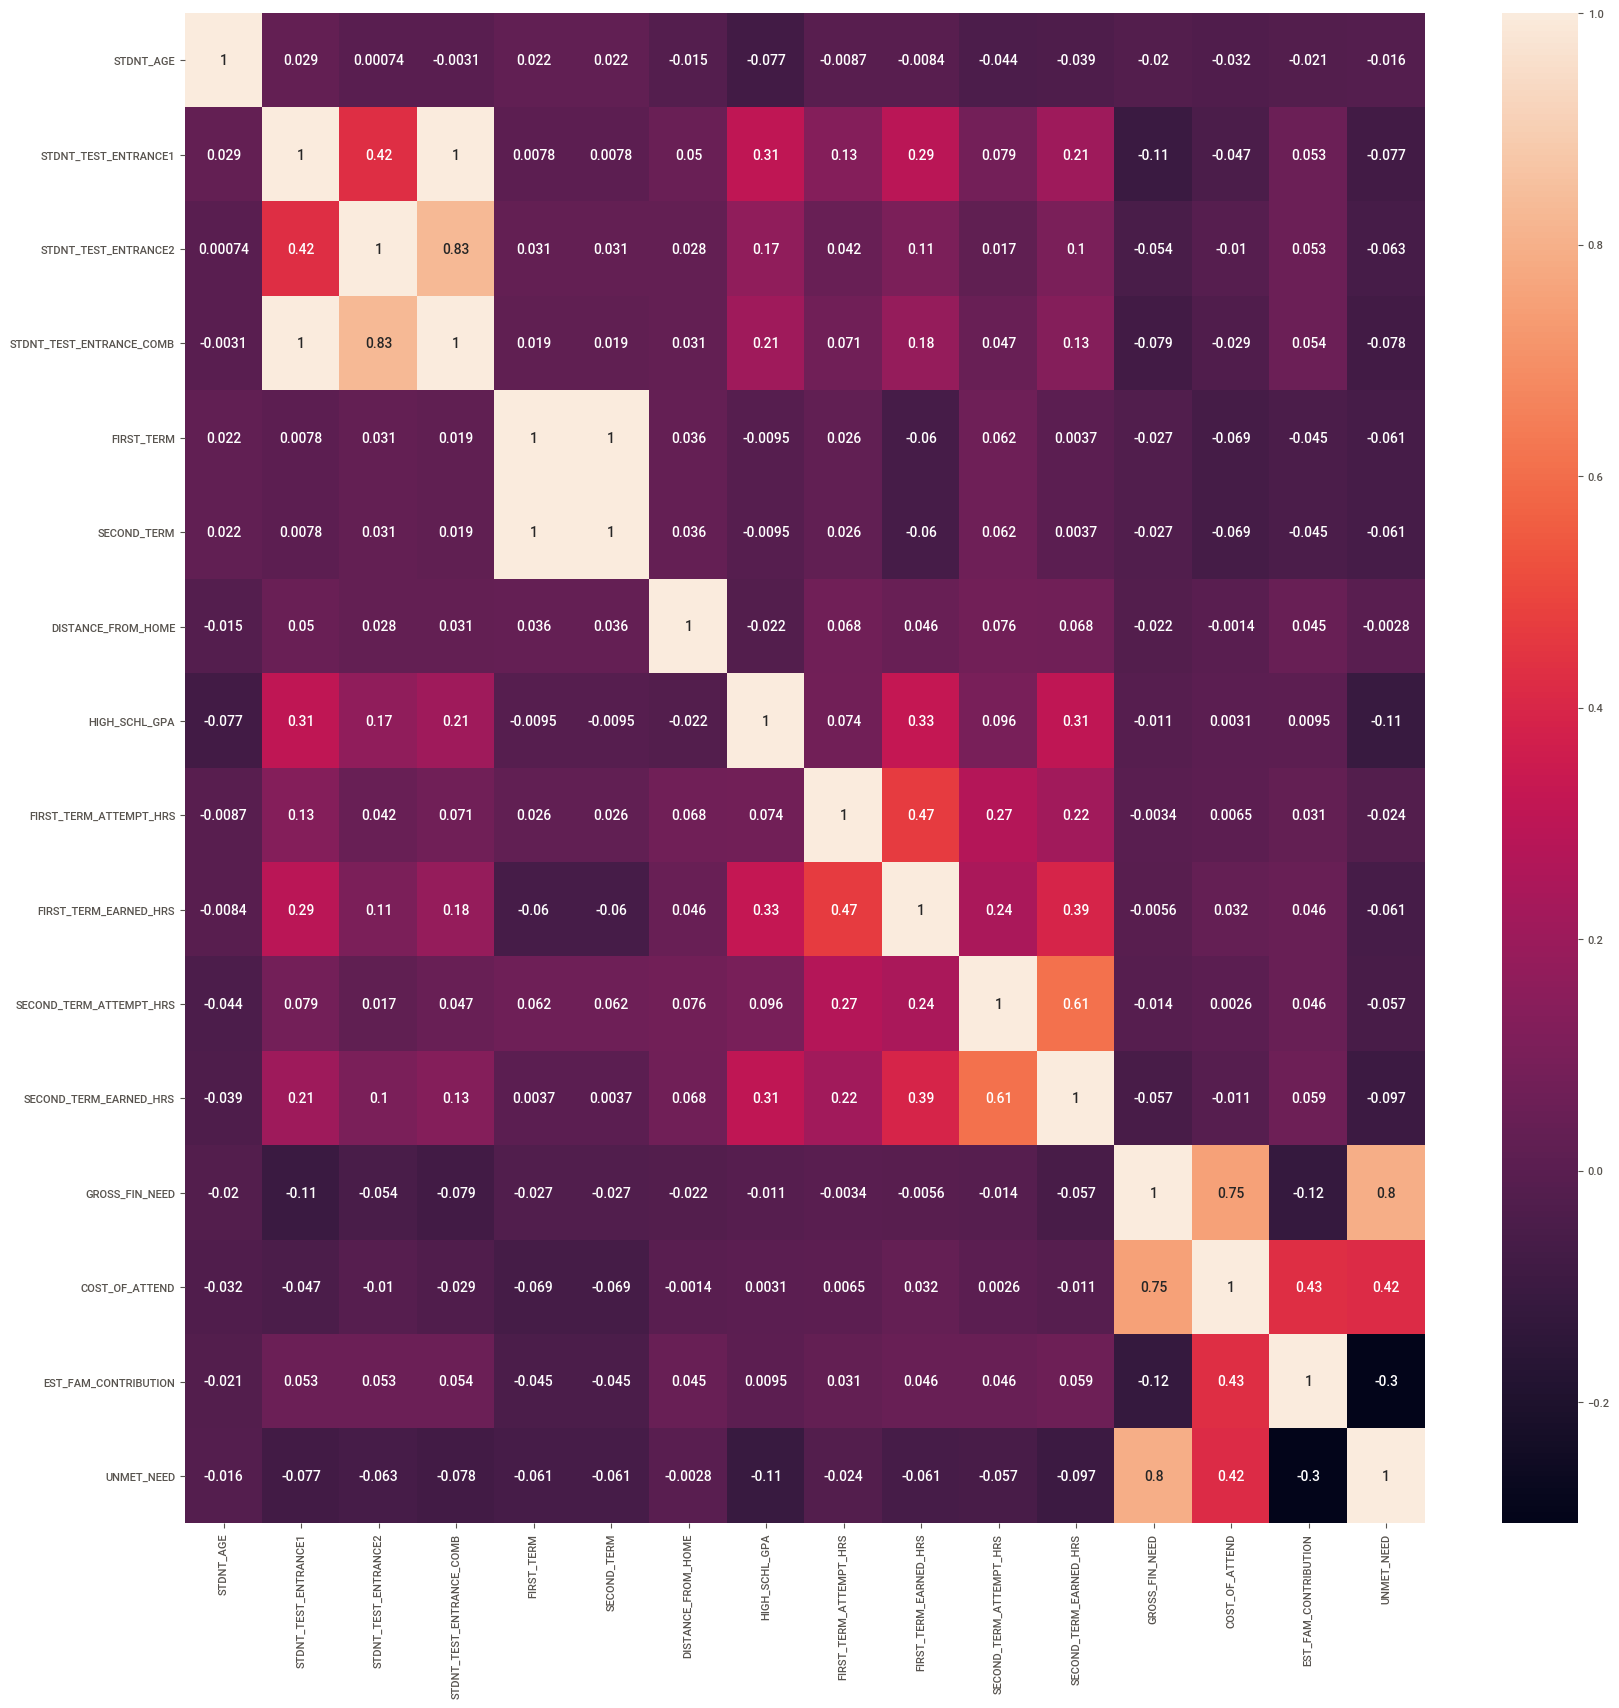

In [44]:
fig, ax = plt.subplots(figsize=(20,20))  
ax = sns.heatmap(StudentApplications.corr(), annot=True)

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(StudentApplications, StudentApplications["Dint_Return_2nd_Yr"]):
    strat_train_set = StudentApplications.loc[train_index]
    strat_test_set = StudentApplications.loc[test_index]

In [10]:
print(strat_train_set["Dint_Return_2nd_Yr"].value_counts())
print(strat_test_set["Dint_Return_2nd_Yr"].value_counts())

0.0    2142
1.0     578
Name: Dint_Return_2nd_Yr, dtype: int64
0.0    535
1.0    145
Name: Dint_Return_2nd_Yr, dtype: int64
